### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D,
                                     Flatten, Dense, Dropout)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pre-processing - Training and Testing sets

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Discipline Specific /4th Model/Preprocessed Non Cancerous '

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20

# =========================== 5) SETUP DATA GENERATORS =======================
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['bkl','df','nv','vasc'],
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['bkl','df','nv','vasc'],
    subset='validation',
    shuffle=False,
    seed=42
)

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


### Building the CNN Model with L2 Regularization and Dropout adjusted to 0.5 (reduce overfitting and improve generalization)

In [ ]:
#  BUILD THE MODEL with L2 Regularization and Adjusted Dropout
model = Sequential([
    # Convolution block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
           kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolution block 2
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolution block 3
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten + Dense
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    # Increased Dropout rate from 0.3 to 0.5
    Dropout(0.5),

    # Output layer (4 classes)
    Dense(4, activation='softmax', kernel_regularizer=l2(1e-4))
])

model.summary()

#  COMPILE THE MODEL
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#  CALLBACK (Early Stopping)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#  TRAIN THE MODEL
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1759s 18s/step - accuracy: 0.3303 - loss: 1.3778 - val_accuracy: 0.5400 - val_loss: 1.1451
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 324ms/step - accuracy: 0.6297 - loss: 0.9873 - val_accuracy: 0.5987 - val_loss: 0.9377
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 361ms/step - accuracy: 0.7049 - loss: 0.8057 - val_accuracy: 0.7212 - val_loss: 0.7820
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step - accuracy: 0.7495 - loss: 0.7370 - val_accuracy: 0.6363 - val_loss: 0.9211
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 317ms/step - accuracy: 0.7437 - loss: 0.7002 - val_accuracy: 0.5525 - val_loss: 0.9136
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 324ms/step - accuracy: 0.7715 - loss: 0.6421 - val_accuracy: 0.7412 - val_loss: 0.6697
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 328ms/step - accuracy: 0.7920 - loss: 0.5824 - val_accuracy: 0.7550 - val_loss: 0.5898
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step - accuracy: 0.8042 - loss: 0

### Evaluation Metrics - Performance of the Model

In [ ]:
#        EVALUATE THE MODEL
print("\nEvaluating on validation data:")
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Evaluating on validation data:
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.7824 - loss: 0.5419
Validation Loss: 0.5149
Validation Accuracy: 0.8000


Confusion Matrix

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step


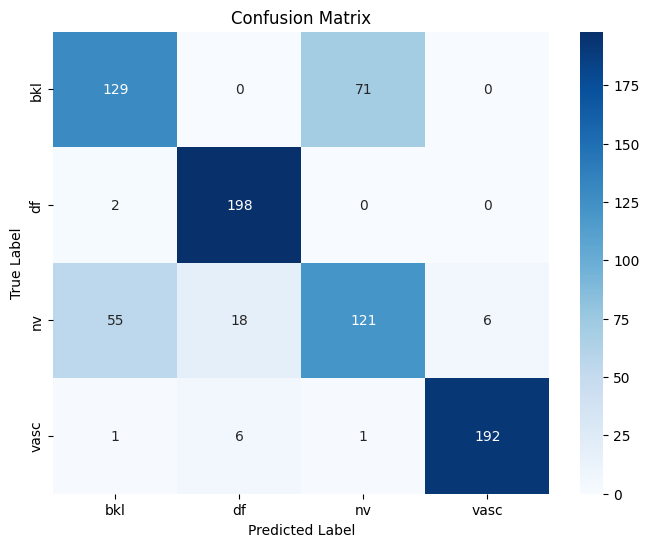

In [ ]:
# Ensure the validation generator is reset
val_generator.reset()

# Compute predictions and true labels
pred_probs = model.predict(val_generator)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = val_generator.classes

# Create a mapping from class indices to class names
class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,              # Show numbers in each cell
    fmt="d",                 # Integer format
    cmap="Blues",            # Color map
    xticklabels=[idx_to_class[i] for i in range(len(idx_to_class))],
    yticklabels=[idx_to_class[i] for i in range(len(idx_to_class))]
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

ROC and AUC Graphs

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step


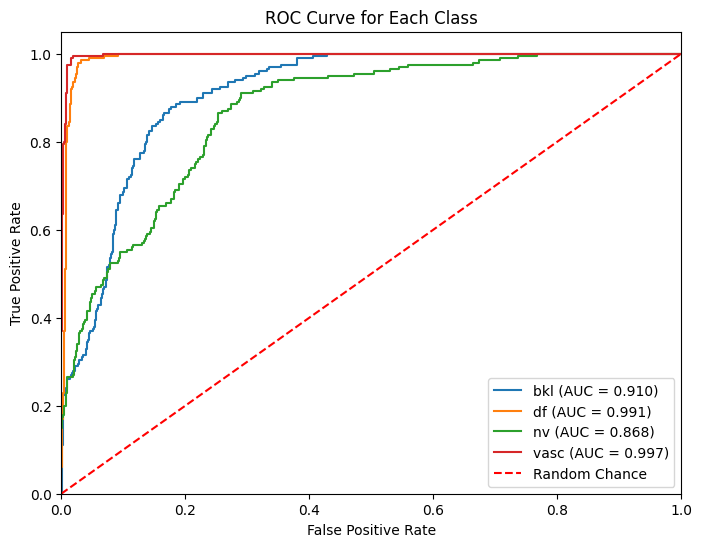

In [ ]:
# Reset validation generator and compute predictions/true labels again
val_generator.reset()
pred_probs = model.predict(val_generator)
true_labels = val_generator.classes

# Create a mapping from class indices to class names
class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Binarize the true labels for a multiclass ROC computation
n_classes = len(idx_to_class)
classes_list = [i for i in range(n_classes)]
true_labels_bin = label_binarize(true_labels, classes=classes_list)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{idx_to_class[i]} (AUC = {roc_auc[i]:.3f})")

# Plot the diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

Training and Validation Graphs and Classification Report

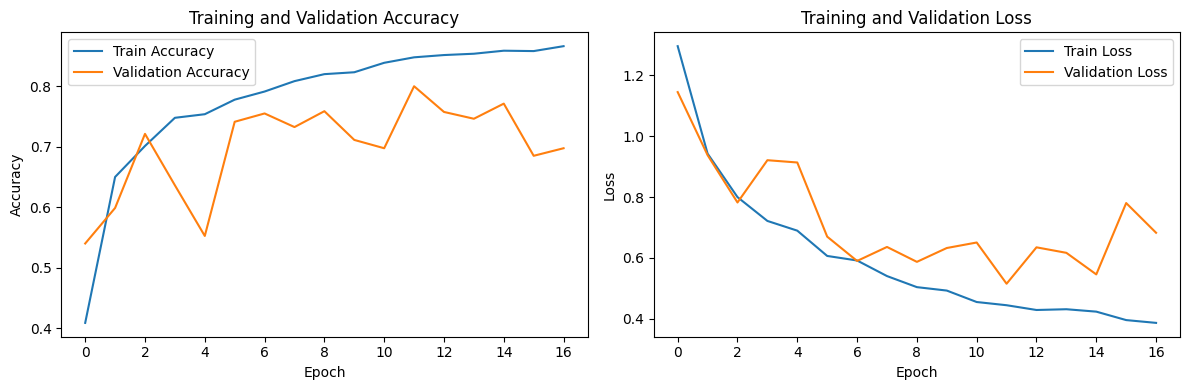

Classification Report:
              precision    recall  f1-score   support

         bkl       0.69      0.65      0.67       200
          df       0.89      0.99      0.94       200
          nv       0.63      0.60      0.62       200
        vasc       0.97      0.96      0.96       200

    accuracy                           0.80       800
   macro avg       0.79      0.80      0.80       800
weighted avg       0.79      0.80      0.80       800



In [ ]:
plt.figure(figsize=(12, 4))

# Plot Accuracy curves
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate and print the classification report
report = classification_report(true_labels, pred_labels, target_names=[idx_to_class[i] for i in range(len(idx_to_class))])
print("Classification Report:")
print(report)